In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

# Preprocess training data
train_data = dataframe_train.drop(dataframe_train.columns[[0, -1]], axis=1)  # Remove date and label columns
train_labels = dataframe_train.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Preprocess testing data
testing_data = dataframe_test.drop(dataframe_test.columns[[0, -1]], axis=1)  # Remove date and label columns
testing_labels = dataframe_test.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Normalize data using training dataset stats
min_val = train_data.min().min()
max_val = train_data.max().max()

train_data = (train_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

# Convert data to TensorFlow tensors
train_data = tf.cast(train_data, tf.float32)
testing_data = tf.cast(testing_data, tf.float32)

# Split normal and anomalous data
normal_train_data = train_data.numpy()[train_labels.to_numpy()]
normal_testing_data = testing_data.numpy()[testing_labels.to_numpy()]
anomalous_train_data = train_data.numpy()[~train_labels.to_numpy()]
anomalous_testing_data = testing_data.numpy()[~testing_labels.to_numpy()]

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.3802 - val_loss: 0.3744
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3733 - val_loss: 0.3633
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3596 - val_loss: 0.3415
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3330 - val_loss: 0.3025
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2880 - val_loss: 0.2448
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2263 - val_loss: 0.1817
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1602 - val_loss: 0.1198
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1045 - val_loss: 0.0852
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0747 - val_loss: 0.0660
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586 - val_loss: 0.0569
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0515 - val_loss: 0.0512
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0460 - val_loss: 0.0473
Epoch 13/

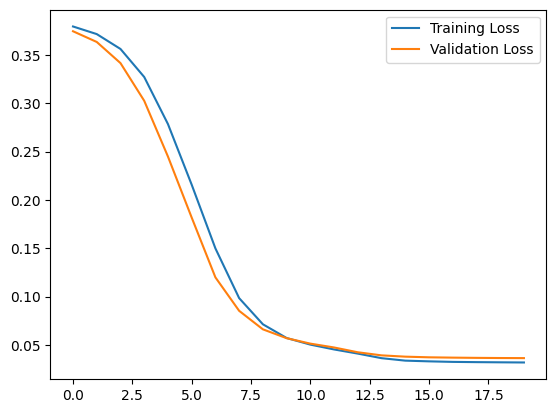

In [ ]:
# Define an autoencoder model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(train_data.shape[1], activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate and compile the model
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

# Train the autoencoder on normal data
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=20,
    batch_size=512,
    validation_data=(normal_testing_data, normal_testing_data),
    shuffle=True
)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


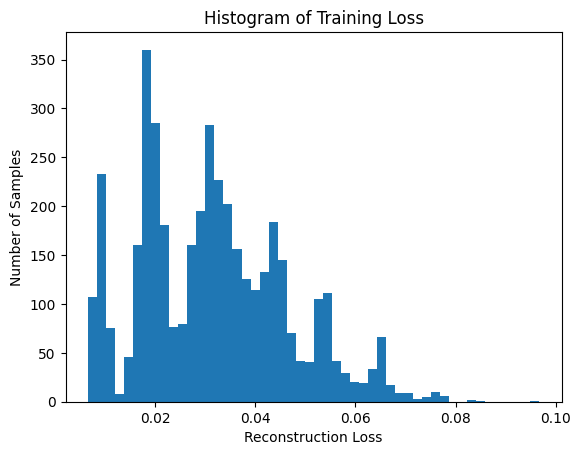

In [ ]:
# Calculate reconstruction loss on normal train data
train_reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(train_reconstructions, normal_train_data)

# Plot histogram of train loss
plt.hist(train_loss.numpy(), bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Histogram of Training Loss")
plt.show()

In [ ]:
# Set threshold for anomaly detection
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# Define a prediction function
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(data, reconstructions)
    return loss < threshold

# Make predictions on the entire test dataset
test_predictions = predict(autoencoder, testing_data, threshold)

# Convert predictions to binary (0 = anomalous, 1 = normal)
test_predictions = test_predictions.numpy().astype(int)

# Evaluate metrics
def print_stats(predictions, labels):
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

# Print the evaluation metrics
print_stats(test_predictions, testing_labels.astype(int))

Threshold:  0.04647773
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.2594542843465773
Precision: 0.1716589861751152
Recall: 0.7321867321867321
F1 Score: 0.27811479234717684
